# Hate Speech Detection

In [2]:
pip install textstat

  Using cached textstat-0.7.1-py3-none-any.whl (99 kB)
  Using cached Pyphen-0.10.0-py3-none-any.whl (1.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as panda
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
dataset = panda.read_csv("annotations_full_nums.csv")
dataset

,Text,Label,class
0,@China_Amb_India Fucking piece of shit your wh...,Anti-Asian Hate,0
1,I’m not being funny but #Coronavirus in.... ...,Neutral,2
2,Got on the Victoria Line today to seven sister...,Anti-Asian Hate,0
3,It's appalling that the media &amp; libtards b...,Anti-Asian Hate,0
4,Dude fuck the Chinese man fuck em and if you t...,Anti-Asian Hate,0
...,...,...,...
7227,"you know what they say, the early bird gets th...",Neutral,2
7228,you're all niggers,Hate,1
7229,you're such a retard i hope you get type 2 dia...,Hate,1
7230,"you've gone and broke the wrong heart baby, an...",Neutral,2


In [3]:
# Adding text-length as a field in the dataset
dataset['text length'] = dataset['Text'].apply(len)
print(dataset.head())

                                                Text            Label  class  \
0  @China_Amb_India Fucking piece of shit your wh...  Anti-Asian Hate      0   
1  I’m not being funny but #Coronavirus in....   ...          Neutral      2   
2  Got on the Victoria Line today to seven sister...  Anti-Asian Hate      0   
3  It's appalling that the media &amp; libtards b...  Anti-Asian Hate      0   
4  Dude fuck the Chinese man fuck em and if you t...  Anti-Asian Hate      0   

   text length  
0          187  
1           98  
2          170  
3          287  
4          102  


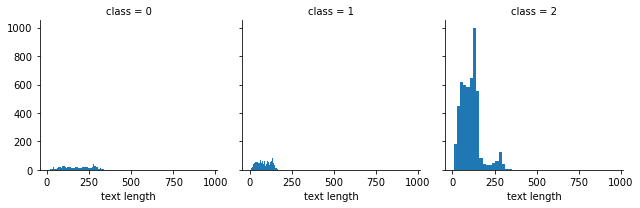

In [4]:
#Basic visualization of data using histograms
# FacetGrid- Multi-plot grid for plotting conditional relationships
import seaborn as sns
import matplotlib.pyplot as plt
graph = sns.FacetGrid(data=dataset, col='class')
graph.map(plt.hist, 'text length', bins=50)

- a.	Distribution of text-length almost seem to be similar across all three classes
- b.	Number of tweets seem to be skewed a lot higher towards the class-1


<AxesSubplot:xlabel='class', ylabel='text length'>

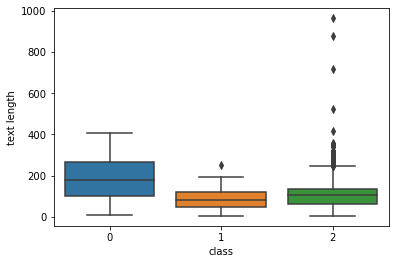

In [5]:
# Box-plot visvualization
sns.boxplot(x='class', y='text length', data=dataset)

From the box-plot, looks like the class-1 tweets have much longer text. There are also outliers present so text-length won’t be a useful feature to consider.

<AxesSubplot:>

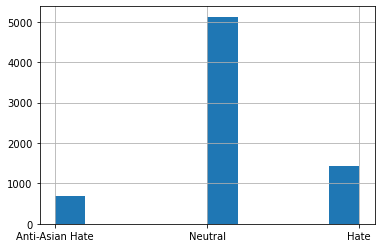

In [6]:
dataset['Label'].hist()

The above histogram shows that most of the tweets are considered to be offensive words by the CF coders.

In [8]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=dataset.Text

## Preprocessing of the tweets

In [16]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [10]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

processed_tweets = preprocess(tweet)   

dataset['processed_tweets'] = processed_tweets
print(dataset[["Text","processed_tweets"]].head(10))

                                                Text  \
0  @China_Amb_India Fucking piece of shit your wh...   
1  I’m not being funny but #Coronavirus in....   ...   
2  Got on the Victoria Line today to seven sister...   
3  It's appalling that the media &amp; libtards b...   
4  Dude fuck the Chinese man fuck em and if you t...   
5  Dear @Twitter Could you please kindly TURN ON ...   
6  @realDonaldTrump so much for it being the Chin...   
7  @BarrazaSdfjbjr @UofAlec You cant blame donald...   
8  Fuck you China and your Chinese virus 😡 Rest i...   
9  China has expelled three WSJ journalists for w...   

                                    processed_tweets  
0  fuck piec shit whole commun sole respons chine...  
1  funni coronaviru china iran itali pretti rando...  
2  got victoria line today seven sister chines cu...  
3  appal media amp libtard bitch viru refer chine...  
4  dude fuck chines man fuck em think say wrong r...  
5  dear could pleas kindli turn moder ppl stop se... 

## Visualizations

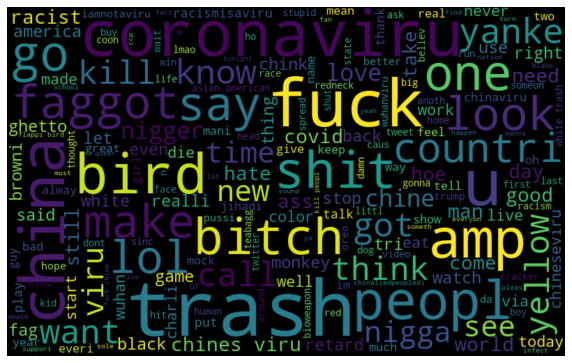

In [13]:
# visualizing which of the word is most commonly used in the twitter dataset
from wordcloud import WordCloud
# imshow-Display data as an image
# interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
all_words = ' '.join([text for text in dataset['processed_tweets'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

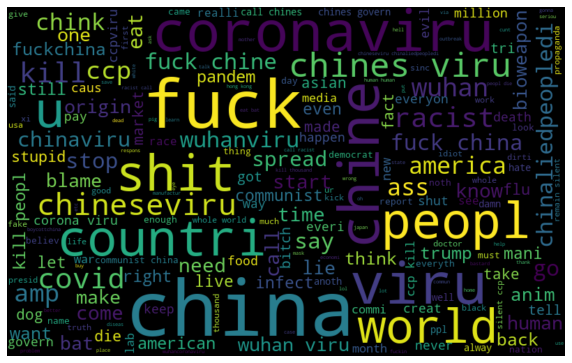

In [14]:
# visualizing which of the word is most commonly used for hatred speech
hatred_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

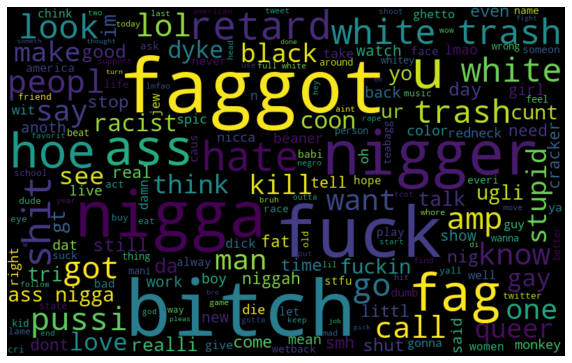

In [15]:
# visualizing which of the word is most commonly used for offensive speech
offensive_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(offensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Feature Engineering

In [16]:
#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )
tfidf

<7232x2841 sparse matrix of type '<class 'numpy.float64'>'
	with 58456 stored elements in Compressed Sparse Row format>

### Running various model Using TFIDF without additional features

In [17]:
# If you don't specify the random_state in the code, 
# then every time you run(execute) your code a new random value is generated 
# and the train and test datasets would have different values each time.
X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)


              precision    recall  f1-score   support

           0       0.84      0.65      0.74       130
           1       0.94      0.72      0.82       294
           2       0.89      0.97      0.93      1023

    accuracy                           0.89      1447
   macro avg       0.89      0.78      0.83      1447
weighted avg       0.90      0.89      0.89      1447

Logistic Regression, Accuracy Score: 0.8949550794747754


In [18]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.85      0.73      0.79       130
           1       0.93      0.82      0.87       294
           2       0.92      0.97      0.95      1023

    accuracy                           0.92      1447
   macro avg       0.90      0.84      0.87      1447
weighted avg       0.92      0.92      0.92      1447

Random Forest, Accuracy Score: 0.9184519695922598


In [19]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_tfidf,y_train)
y_preds = nb.predict(X_test_tfidf)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.47      0.55      0.51       130
           1       0.45      0.68      0.54       294
           2       0.84      0.70      0.76      1023

    accuracy                           0.68      1447
   macro avg       0.59      0.64      0.60      1447
weighted avg       0.73      0.68      0.69      1447

Naive Bayes, Accuracy Score: 0.6800276434001382


In [20]:
support =LinearSVC(random_state=20)
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.74      0.73      0.74       130
           1       0.89      0.80      0.84       294
           2       0.92      0.95      0.93      1023

    accuracy                           0.90      1447
   macro avg       0.85      0.82      0.84      1447
weighted avg       0.90      0.90      0.90      1447

SVM, Accuracy Score: 0.8963372494816862


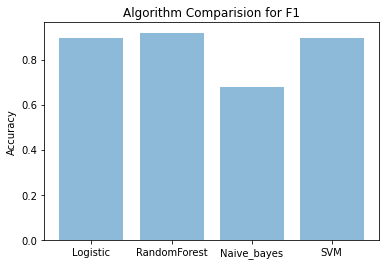

In [21]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for F1')
plt.show()

### Sentiment Analysis, using polarity scores as features

In [31]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kavitaselva/nltk_data...


True

In [22]:

sentiment_analyzer = VS()
def count_tags(tweet_c):  
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(tweet):   
    sentiment = sentiment_analyzer.polarity_scores(tweet)    
    twitter_objs = count_tags(tweet)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(tweet)
#final_features

new_features = panda.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features

,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.114,0.145,0.740,0.0094,0.0,1.0,0.0
1,0.288,0.188,0.524,-0.3189,0.0,0.0,1.0
2,0.289,0.000,0.711,-0.9042,0.0,0.0,0.0
3,0.353,0.106,0.541,-0.9670,0.0,0.0,0.0
4,0.497,0.000,0.503,-0.9413,0.0,0.0,0.0
...,...,...,...,...,...,...,...
7227,0.000,0.000,1.000,0.0000,0.0,0.0,0.0
7228,0.000,0.000,1.000,0.0000,0.0,0.0,0.0
7229,0.430,0.104,0.466,-0.8777,0.0,1.0,0.0
7230,0.454,0.000,0.546,-0.8074,0.0,0.0,0.0


In [23]:
# F2-Conctaenation of tf-idf scores and sentiment scores
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(7232, 2848)

### Running various model Using TFIDF and additional features

In [24]:
# Running the model Using TFIDF with some features from sentiment analysis

X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression,Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.78      0.63      0.70       130
           1       0.93      0.72      0.81       294
           2       0.89      0.96      0.92      1023

    accuracy                           0.89      1447
   macro avg       0.86      0.77      0.81      1447
weighted avg       0.89      0.89      0.88      1447

Logistic Regression,Accuracy Score: 0.8852798894263995


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.82      0.62      0.71       130
           1       0.91      0.80      0.85       294
           2       0.91      0.96      0.93      1023

    accuracy                           0.90      1447
   macro avg       0.88      0.80      0.83      1447
weighted avg       0.90      0.90      0.90      1447

Random Forest, Accuracy Score: 0.9004837595024188


In [26]:
X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_bow,y_train)
y_preds = nb.predict(X_test_bow)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.48      0.56      0.52       130
           1       0.45      0.68      0.54       294
           2       0.84      0.70      0.76      1023

    accuracy                           0.68      1447
   macro avg       0.59      0.65      0.61      1447
weighted avg       0.73      0.68      0.70      1447

Naive Bayes, Accuracy Score: 0.6821008984105045


In [27]:
X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       130
           1       0.89      0.80      0.84       294
           2       0.92      0.95      0.93      1023

    accuracy                           0.90      1447
   macro avg       0.85      0.82      0.84      1447
weighted avg       0.90      0.90      0.90      1447

SVM, Accuracy Score: 0.8977194194885971


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


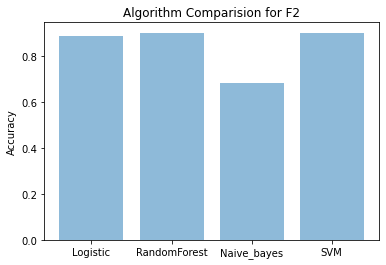

In [28]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for F2')
plt.show()

In [42]:
pip install python-Levenshtein

     |████████████████████████████████| 50 kB 1.5 MB/s eta 0:00:011
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp38-cp38-macosx_10_9_x86_64.whl size=81465 sha256=f0db43c905bdda5fb94a3ad0ebb719d61bd9e14395c431a8f795c35dbc1d44ae
  Stored in directory: /Users/kavitaselva/Library/Caches/pip/wheels/d7/0c/76/042b46eb0df65c3ccd0338f791210c55ab79d209bcc269e2c7
Successfully built python-Levenshtein
Note: you may need to restart the kernel to use updated packages.


In [29]:
# create doc2vec vector columns
# Initialize and train the model
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#The input for a Doc2Vec model should be a list of TaggedDocument(['list','of','word'], [TAG_001]). 
#A good practice is using the indexes of sentences as the tags.
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dataset["processed_tweets"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
# window- The maximum distance between the current and predicted word within a sentence.
# mincount-Ignores all words with total frequency lower than this.
# workers -Use these many worker threads to train the model
#  Training Model - distributed bag of words (PV-DBOW) is employed.
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

#infer_vector - Infer a vector for given post-bulk training document.
# Syntax- infer_vector(doc_words, alpha=None, min_alpha=None, epochs=None, steps=None)
# doc_words-A document for which the vector representation will be inferred.

# transform each document into a vector data
doc2vec_df = dataset["processed_tweets"].apply(lambda x: model.infer_vector(x.split(" "))).apply(panda.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
doc2vec_df

,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,-0.041601,0.164616,0.285553,-0.139801,-0.086635
1,0.021901,0.102461,0.102872,-0.026783,-0.004990
2,0.178637,0.241782,0.445152,-0.148945,-0.054951
3,0.131690,0.182004,0.301905,-0.221857,-0.012361
4,-0.142609,0.023705,0.212777,-0.053551,-0.038927
...,...,...,...,...,...
7227,0.128622,0.135383,0.074879,-0.058447,-0.045188
7228,0.100439,-0.008064,0.066937,-0.019842,-0.009104
7229,0.180055,0.129701,0.196862,-0.173529,-0.105848
7230,0.184651,0.201049,0.170158,-0.201033,-0.059142


In [30]:
# conctaenation of tf-idf scores, sentiment scores and doc2vec columns
modelling_features = np.concatenate([tfidf_a,final_features,doc2vec_df],axis=1)
modelling_features.shape

(7232, 2853)

### Running the models Using TFIDF with additional features from sentiment analysis and doc2vec

In [31]:
X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.79      0.66      0.72       130
           1       0.92      0.75      0.83       294
           2       0.90      0.96      0.93      1023

    accuracy                           0.89      1447
   macro avg       0.87      0.79      0.83      1447
weighted avg       0.89      0.89      0.89      1447

Logistic Regression, Accuracy Score: 0.8928818244644091


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.80      0.60      0.68       130
           1       0.91      0.76      0.83       294
           2       0.90      0.97      0.93      1023

    accuracy                           0.89      1447
   macro avg       0.87      0.78      0.82      1447
weighted avg       0.89      0.89      0.89      1447

Random Forest, Accuracy Score: 0.8921907394609537


In [33]:
X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train,y_train)
y_preds = nb.predict(X_test)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.48      0.56      0.52       130
           1       0.45      0.68      0.54       294
           2       0.84      0.70      0.76      1023

    accuracy                           0.68      1447
   macro avg       0.59      0.65      0.61      1447
weighted avg       0.73      0.68      0.70      1447

Naive Bayes, Accuracy Score: 0.6821008984105045


In [34]:
X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       130
           1       0.88      0.80      0.84       294
           2       0.92      0.95      0.93      1023

    accuracy                           0.90      1447
   macro avg       0.85      0.82      0.84      1447
weighted avg       0.90      0.90      0.90      1447

SVM, Accuracy Score: 0.8970283344851416


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


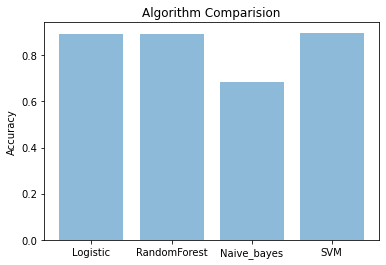

In [35]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision')
plt.show()

### Setting up Using TFIDF with sentiment scores,doc2vec, and anti-asian one hot vector

In [39]:
hate_certain = ['aseng', 'bamboo coon', 'bamboo coons', 'bat eater', 'bioterrorism', 'bioweapon', 'boycottchina', 'ccpvirus', 'chinadidthis', 'chinaliedpeopledie', 'chinaliedpeopledied', 'chinaman', 'chinamen', 'chinavirus', 'ching chong', 'chink', 'chinky', 'cokin', 'commie', 'commies', 'communistvirus', 'coolie', 'dog eater', 'fuckchina', 'kungflu', 'ling ling', 'makechinapay', 'niakoué', 'pastel de flango', 'sideways cooters', 'sideways pussies', 'sideways pussy', 'sideways vagina', 'sideways vagina', 'slant-eye', 'slopehead', 'ting tong', 'wuflu', 'wuhanflu', 'wuhanvirus']
hate_possible = ['asia', 'asian', 'beijing', 'ccp', 'china', 'chinese', 'ckmb', 'communist', 'communists', 'cpc', 'huanan', 'hubei', 'jinping', 'patient zero', 'prc', 'tedros', 'wuhan', 'xi jinping', 'xijinping', 'xinnie']
check_terms = hate_certain + hate_possible

In [40]:
def hate_vec(text, regex_list):
    """
        Generates a feature vector for text with one hot encodings to represent whether each
        regular expression in regex_list was a match.

        Parameters
        -----------------
        text : str, any string
        regex_list : array-like, a list of compiled regular expressions
    """
    text = text.lower()
    vec = np.zeros(len(regex_list))
    for i, regex in enumerate(regex_list):
        if len(regex.findall(text)) > 0:
            vec[i] = 1
    return vec

def hate_features(tweet_series):
    """
        Returns a 2-dimensional numpy array of hate_vec feature vectors for each tweet in
        tweet_series.

        Parameters
        -----------------
        tweet_series : array-like, a list of string representations of tweets
    """

    hate_certain = ['aseng', 'bamboo coon', 'bamboo coons', 'bat eater', 'bioterrorism', 'bioweapon', 'boycottchina', 'ccpvirus', 'chinadidthis', 'chinaliedpeopledie', 'chinaliedpeopledied', 'chinaman', 'chinamen', 'chinavirus', 'ching chong', 'chink', 'chinky', 'cokin', 'commie', 'commies', 'communistvirus', 'coolie', 'dog eater', 'fuckchina', 'kungflu', 'ling ling', 'makechinapay', 'niakoué', 'pastel de flango', 'sideways cooters', 'sideways pussies', 'sideways pussy', 'sideways vagina', 'sideways vagina', 'slant-eye', 'slopehead', 'ting tong', 'wuflu', 'wuhanflu', 'wuhanvirus']
    hate_possible = ['asia', 'asian', 'beijing', 'ccp', 'china', 'chinese', 'ckmb', 'communist', 'communists', 'cpc', 'huanan', 'hubei', 'jinping', 'patient zero', 'prc', 'tedros', 'wuhan', 'xi jinping', 'xijinping', 'xinnie']
    check_terms = hate_certain + hate_possible
    regex_list = [re.compile(word) for word in check_terms]

    return np.array([hate_vec(txt, regex_list) for txt in tweet_series])

In [44]:
anti_asian_vocab_features = hate_features(tweet)
anti_asian_vocab_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [45]:
anti_asian_vocab_features_df = panda.DataFrame(anti_asian_vocab_features)
anti_asian_vocab_features_df

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
anti_asian_vocab_features_df.columns = [check_terms[i] for i in range(0, len(check_terms))]
anti_asian_vocab_features_df

,aseng,bamboo coon,bamboo coons,bat eater,bioterrorism,bioweapon,boycottchina,ccpvirus,chinadidthis,chinaliedpeopledie,...,huanan,hubei,jinping,patient zero,prc,tedros,wuhan,xi jinping,xijinping,xinnie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# conctaenation of tf-idf scores, sentiment scores and doc2vec columns
modelling_features_antiasian = np.concatenate([tfidf_a,final_features,doc2vec_df, anti_asian_vocab_features_df],axis=1)
modelling_features_antiasian.shape

(7232, 2913)

### Running TFIDF with sentiment scores,doc2vec, and anti-asian one hot vector

In [51]:
X = panda.DataFrame(modelling_features_antiasian)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.84      0.79      0.82       130
           1       0.94      0.75      0.83       294
           2       0.91      0.97      0.94      1023

    accuracy                           0.91      1447
   macro avg       0.90      0.84      0.86      1447
weighted avg       0.91      0.91      0.91      1447

Logistic Regression, Accuracy Score: 0.9087767795438839


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
X = panda.DataFrame(modelling_features_antiasian)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.79      0.68      0.73       130
           1       0.92      0.76      0.83       294
           2       0.90      0.96      0.93      1023

    accuracy                           0.90      1447
   macro avg       0.87      0.80      0.83      1447
weighted avg       0.89      0.90      0.89      1447

Random Forest, Accuracy Score: 0.8956461644782309


In [53]:
X = panda.DataFrame(modelling_features_antiasian)
y = dataset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train,y_train)
y_preds = nb.predict(X_test)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.47      0.55      0.51       130
           1       0.45      0.69      0.55       294
           2       0.84      0.70      0.76      1023

    accuracy                           0.68      1447
   macro avg       0.59      0.64      0.60      1447
weighted avg       0.73      0.68      0.69      1447

Naive Bayes, Accuracy Score: 0.6814098134070491


In [54]:
X = panda.DataFrame(modelling_features_antiasian)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       130
           1       0.88      0.80      0.84       294
           2       0.92      0.95      0.93      1023

    accuracy                           0.90      1447
   macro avg       0.86      0.84      0.85      1447
weighted avg       0.90      0.90      0.90      1447

SVM, Accuracy Score: 0.902557014512785


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


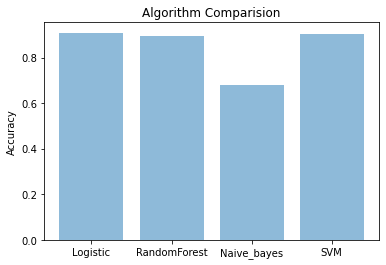

In [55]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision')
plt.show()

### Setting up bert instead of doc2vec

In [57]:
import torch
from transformers import AutoModel, AutoTokenizer

In [58]:
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")

In [74]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [76]:
line = tweet[0]
line

'@China_Amb_India Fucking piece of shit your whole community is solely responsible for the Chinese virus. Chinese dipshits should apologise to the world for their existence on this planet.'

In [77]:
input_ids = torch.tensor([tokenizer.encode(line)])
input_ids

tensor([[    0,     5,  4389,  1344,    15,   145,    44,   434,  1506,    17,
         16608,  3965,    19,     6,  2209,  4892,     4,  2209, 51208,  6117,
           151, 16091,     9,     6,   220,    19,   130,  5731,    24,    33,
          3615,     4,     2]])

In [78]:
with torch.no_grad():
    features = bertweet(input_ids)  # Models outputs are now tuples

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.1470,  0.2194,  0.3548,  ..., -0.0928, -0.0067, -0.1248],
         [ 0.2243, -0.0667,  0.0637,  ..., -0.2476,  0.1714, -0.2776],
         [ 0.0293,  0.2343,  0.5522,  ...,  0.2034,  0.2209, -0.4127],
         ...,
         [-0.2278,  0.1269, -0.1208,  ...,  0.3433,  0.3473,  0.0511],
         [-0.0042,  0.1494,  0.2441,  ...,  0.2700, -0.2677, -0.4144],
         [-0.1756,  0.2342,  0.3657,  ..., -0.1384,  0.0314, -0.0999]]]), pooler_output=tensor([[ 1.1840e-01, -2.5016e-01,  9.1815e-02, -1.6193e-01,  8.9089e-02,
         -1.4507e-01,  7.4233e-02, -6.3076e-02,  1.9510e-01, -1.0226e-01,
         -7.8767e-02, -1.5062e-02, -2.1287e-01,  1.1001e-01,  1.9204e-01,
         -8.3919e-02, -2.5265e-01, -1.5292e-01, -7.1874e-03,  5.5051e-02,
         -1.3225e-01, -2.2436e-01,  3.7860e-01, -5.6462e-02,  3.0936e-02,
          1.3792e-01, -2.1605e-01, -1.2501e-01,  1.6271e-03, -1.2854e-01,
          2.1865e-02, -2.0885e-01,  

In [82]:
np.array(features.pooler_output[0]).shape

(768,)

In [83]:
def bert_features(t):
    input_ids = torch.tensor([tokenizer.encode(t)])
    features = None
    with torch.no_grad():
        features = bertweet(input_ids)
    return np.array(features.pooler_output[0])
        
def bert(tweets):
    return np.array([bert_features(t) for t in tweets])

In [85]:
bert_feats = bert(tweet)
bert_feats

array([[ 0.11840212, -0.25015682,  0.09181527, ..., -0.05746007,
        -0.08526689, -0.1856025 ],
       [ 0.25955433, -0.19519822,  0.0394407 , ..., -0.06952012,
        -0.1212983 , -0.16060828],
       [ 0.29192495, -0.20256363,  0.08363147, ..., -0.05919142,
        -0.11933856, -0.14920184],
       ...,
       [ 0.16708776, -0.22839512,  0.06042372, ..., -0.03528869,
        -0.08737121, -0.19110546],
       [ 0.16309036, -0.15961175,  0.02913156, ..., -0.08279724,
        -0.14368282, -0.24073394],
       [ 0.184994  , -0.12984551,  0.09466802, ...,  0.04397279,
        -0.17632215, -0.19267857]], dtype=float32)

In [86]:
bert_feats.shape

(7232, 768)

In [87]:
bert_feats_df = panda.DataFrame(bert_feats)
bert_feats_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.118402,-0.250157,0.091815,-0.161926,0.089089,-0.145073,0.074233,-0.063076,0.195104,-0.102257,...,-0.135560,-0.220144,-0.131224,0.219201,0.127591,0.275199,-0.300551,-0.057460,-0.085267,-0.185603
1,0.259554,-0.195198,0.039441,-0.159995,0.084989,-0.159862,0.079374,-0.106867,0.200631,-0.122103,...,-0.037991,-0.299643,-0.251789,0.118384,0.106208,0.246883,-0.336195,-0.069520,-0.121298,-0.160608
2,0.291925,-0.202564,0.083631,-0.220291,0.144640,-0.216650,0.158189,-0.208227,0.196723,-0.174190,...,-0.043169,-0.259466,-0.220516,0.185871,0.133562,0.254977,-0.338651,-0.059191,-0.119339,-0.149202
3,0.138020,-0.253287,0.083141,-0.204872,0.122039,-0.216853,0.128486,-0.086050,0.171786,-0.087008,...,-0.154578,-0.284557,-0.123930,0.194615,0.135981,0.228602,-0.434013,-0.082703,-0.134871,-0.240171
4,0.223567,-0.236848,0.084042,-0.114145,0.091284,-0.219878,0.064651,-0.107565,0.176456,-0.046933,...,-0.129159,-0.284803,-0.248845,0.169470,0.055243,0.235614,-0.384076,-0.112851,-0.071213,-0.220167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7227,0.280773,-0.221125,0.029177,-0.189790,0.105735,-0.236031,0.108876,-0.094062,0.155338,-0.077043,...,-0.131542,-0.266288,-0.168899,0.194437,0.100257,0.254390,-0.341578,-0.071265,-0.117436,-0.256359
7228,0.228569,-0.163879,0.000868,-0.221815,0.130785,-0.162066,0.072085,-0.068443,0.224180,-0.072985,...,-0.116569,-0.353815,-0.191268,0.172369,0.071438,0.285922,-0.389097,-0.161913,-0.132773,-0.206887
7229,0.167088,-0.228395,0.060424,-0.219880,0.044164,-0.226387,0.064585,-0.108062,0.160988,-0.133177,...,-0.096453,-0.297686,-0.210198,0.246831,0.116361,0.257340,-0.290134,-0.035289,-0.087371,-0.191105
7230,0.163090,-0.159612,0.029132,-0.193365,0.035368,-0.169096,0.133585,-0.102174,0.090645,-0.059387,...,-0.107150,-0.233529,-0.217643,0.121025,0.092287,0.266127,-0.404635,-0.082797,-0.143683,-0.240734


In [88]:
bert_feats_df.columns = ["bert_feats_df_vector_" + str(x) for x in bert_feats_df.columns]
bert_feats_df

,bert_feats_df_vector_0,bert_feats_df_vector_1,bert_feats_df_vector_2,bert_feats_df_vector_3,bert_feats_df_vector_4,bert_feats_df_vector_5,bert_feats_df_vector_6,bert_feats_df_vector_7,bert_feats_df_vector_8,bert_feats_df_vector_9,...,bert_feats_df_vector_758,bert_feats_df_vector_759,bert_feats_df_vector_760,bert_feats_df_vector_761,bert_feats_df_vector_762,bert_feats_df_vector_763,bert_feats_df_vector_764,bert_feats_df_vector_765,bert_feats_df_vector_766,bert_feats_df_vector_767
0,0.118402,-0.250157,0.091815,-0.161926,0.089089,-0.145073,0.074233,-0.063076,0.195104,-0.102257,...,-0.135560,-0.220144,-0.131224,0.219201,0.127591,0.275199,-0.300551,-0.057460,-0.085267,-0.185603
1,0.259554,-0.195198,0.039441,-0.159995,0.084989,-0.159862,0.079374,-0.106867,0.200631,-0.122103,...,-0.037991,-0.299643,-0.251789,0.118384,0.106208,0.246883,-0.336195,-0.069520,-0.121298,-0.160608
2,0.291925,-0.202564,0.083631,-0.220291,0.144640,-0.216650,0.158189,-0.208227,0.196723,-0.174190,...,-0.043169,-0.259466,-0.220516,0.185871,0.133562,0.254977,-0.338651,-0.059191,-0.119339,-0.149202
3,0.138020,-0.253287,0.083141,-0.204872,0.122039,-0.216853,0.128486,-0.086050,0.171786,-0.087008,...,-0.154578,-0.284557,-0.123930,0.194615,0.135981,0.228602,-0.434013,-0.082703,-0.134871,-0.240171
4,0.223567,-0.236848,0.084042,-0.114145,0.091284,-0.219878,0.064651,-0.107565,0.176456,-0.046933,...,-0.129159,-0.284803,-0.248845,0.169470,0.055243,0.235614,-0.384076,-0.112851,-0.071213,-0.220167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7227,0.280773,-0.221125,0.029177,-0.189790,0.105735,-0.236031,0.108876,-0.094062,0.155338,-0.077043,...,-0.131542,-0.266288,-0.168899,0.194437,0.100257,0.254390,-0.341578,-0.071265,-0.117436,-0.256359
7228,0.228569,-0.163879,0.000868,-0.221815,0.130785,-0.162066,0.072085,-0.068443,0.224180,-0.072985,...,-0.116569,-0.353815,-0.191268,0.172369,0.071438,0.285922,-0.389097,-0.161913,-0.132773,-0.206887
7229,0.167088,-0.228395,0.060424,-0.219880,0.044164,-0.226387,0.064585,-0.108062,0.160988,-0.133177,...,-0.096453,-0.297686,-0.210198,0.246831,0.116361,0.257340,-0.290134,-0.035289,-0.087371,-0.191105
7230,0.163090,-0.159612,0.029132,-0.193365,0.035368,-0.169096,0.133585,-0.102174,0.090645,-0.059387,...,-0.107150,-0.233529,-0.217643,0.121025,0.092287,0.266127,-0.404635,-0.082797,-0.143683,-0.240734


In [89]:
# conctaenation of tf-idf scores, sentiment scores and doc2vec columns
modelling_features_bert = np.concatenate([tfidf_a,final_features,bert_feats_df],axis=1)
modelling_features_bert.shape

(7232, 3616)

### Running w/ tfidf, sentiment, and bert

In [90]:
X = panda.DataFrame(modelling_features_bert)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.77      0.72      0.75       130
           1       0.91      0.79      0.85       294
           2       0.91      0.96      0.93      1023

    accuracy                           0.90      1447
   macro avg       0.86      0.82      0.84      1447
weighted avg       0.90      0.90      0.90      1447

Logistic Regression, Accuracy Score: 0.9004837595024188


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [91]:
X = panda.DataFrame(modelling_features_bert)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.84      0.47      0.60       130
           1       0.92      0.37      0.53       294
           2       0.80      0.99      0.89      1023

    accuracy                           0.82      1447
   macro avg       0.85      0.61      0.67      1447
weighted avg       0.83      0.82      0.79      1447

Random Forest, Accuracy Score: 0.8154803040774016


In [93]:
X = panda.DataFrame(modelling_features_bert)
y = dataset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train,y_train)
y_preds = nb.predict(X_test)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.48      0.55      0.51       130
           1       0.45      0.68      0.54       294
           2       0.84      0.70      0.76      1023

    accuracy                           0.68      1447
   macro avg       0.59      0.64      0.61      1447
weighted avg       0.73      0.68      0.69      1447

Naive Bayes, Accuracy Score: 0.6814098134070491


In [92]:
X = panda.DataFrame(modelling_features_bert)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       130
           1       0.89      0.81      0.85       294
           2       0.93      0.95      0.94      1023

    accuracy                           0.91      1447
   macro avg       0.86      0.85      0.86      1447
weighted avg       0.91      0.91      0.91      1447

SVM, Accuracy Score: 0.9067035245335177


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


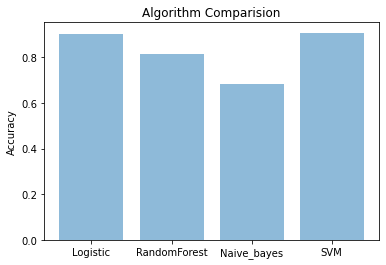

In [94]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision')
plt.show()

### Setting up tfidf, sentiment, bert, and asian american

In [96]:
bert_antiasian_features = np.concatenate([tfidf_a,final_features,bert_feats_df, anti_asian_vocab_features_df],axis=1)
bert_antiasian_features.shape

(7232, 3676)

In [97]:
X = panda.DataFrame(bert_antiasian_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.78      0.77      0.78       130
           1       0.91      0.79      0.85       294
           2       0.92      0.96      0.94      1023

    accuracy                           0.90      1447
   macro avg       0.87      0.84      0.85      1447
weighted avg       0.90      0.90      0.90      1447

Logistic Regression, Accuracy Score: 0.9046302695231514


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [98]:
X = panda.DataFrame(bert_antiasian_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.82      0.49      0.62       130
           1       0.95      0.39      0.56       294
           2       0.81      0.99      0.89      1023

    accuracy                           0.82      1447
   macro avg       0.86      0.62      0.69      1447
weighted avg       0.84      0.82      0.80      1447

Random Forest, Accuracy Score: 0.821008984105045


In [99]:
X = panda.DataFrame(bert_antiasian_features)
y = dataset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train,y_train)
y_preds = nb.predict(X_test)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.47      0.55      0.51       130
           1       0.45      0.69      0.54       294
           2       0.84      0.70      0.76      1023

    accuracy                           0.68      1447
   macro avg       0.59      0.64      0.60      1447
weighted avg       0.73      0.68      0.69      1447

Naive Bayes, Accuracy Score: 0.6807187284035936


In [100]:
X = panda.DataFrame(bert_antiasian_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       130
           1       0.89      0.82      0.86       294
           2       0.93      0.95      0.94      1023

    accuracy                           0.91      1447
   macro avg       0.86      0.85      0.86      1447
weighted avg       0.91      0.91      0.91      1447

SVM, Accuracy Score: 0.9067035245335177


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


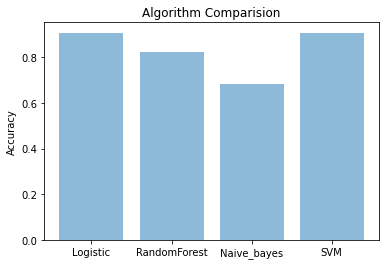

In [101]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision')
plt.show()

### Setting up Enhanced Features

In [102]:
#Using TFIDF with sentiment scores,doc2vec and enhanced features
def additional_features(tweet): 
    
    syllables = textstat.syllable_count(tweet)
    num_chars = sum(len(w) for w in tweet)
    num_chars_total = len(tweet)
    num_words = len(tweet.split())
    # avg_syl = total syllables/ total words
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(tweet.split()))
    
    #  Flesch–Kincaid readability tests are readability tests 
    #  designed to indicate how difficult a passage in English is to understand. 
    # There are two tests, the Flesch Reading Ease, and the Flesch–Kincaid Grade 
    # A text with a comparatively high score on FRE test should have a lower score on the FKRA test.
    # Reference - https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
    
    ###Modified FK grade, where avg words per sentence is : just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    add_features=[FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_words,
                num_unique_terms]
    return add_features

def get_additonal_feature_array(tweets):
    features=[]
    for t in tweets:
        features.append(additional_features(t))
    return np.array(features)

fFeatures = get_additonal_feature_array(processed_tweets)


In [103]:
tfidf_a = tfidf.toarray()
modelling_features_enhanced = np.concatenate([tfidf_a,final_features,doc2vec_df,fFeatures],axis=1)
modelling_features_enhanced.shape

(7232, 2861)

### tfidf, sentiment, doc2vec, anti asian, and enhanced

In [124]:
tfidf_a = tfidf.toarray()
modelling_features_enhanced_antiasian = np.concatenate([tfidf_a,final_features,doc2vec_df,anti_asian_vocab_features_df,fFeatures],axis=1)
modelling_features_enhanced_antiasian.shape

(7232, 2921)

In [125]:
# Running the model Using TFIDF with enhanced features

X = panda.DataFrame(modelling_features_enhanced_antiasian)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

model = LogisticRegression().fit(X_train_features,y_train)
y_preds = model.predict(X_test_features)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.81      0.60      0.69       130
           1       0.69      0.48      0.57       305
           2       0.83      0.93      0.87      1012

    accuracy                           0.81      1447
   macro avg       0.78      0.67      0.71      1447
weighted avg       0.80      0.81      0.79      1447

Logistic Regression, Accuracy Score: 0.8058051140290255


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [126]:
#Using TFIDF with sentiment scores,doc2vec and enhanced features
def additional_features_num(tweet): 
    
    num_chars = sum(len(w) for w in tweet)
    num_words = len(tweet.split())
    # avg_syl = total syllables/ total words
    num_unique_terms = len(set(tweet.split()))
    
    #  Flesch–Kincaid readability tests are readability tests 
    #  designed to indicate how difficult a passage in English is to understand. 
    # There are two tests, the Flesch Reading Ease, and the Flesch–Kincaid Grade 
    # A text with a comparatively high score on FRE test should have a lower score on the FKRA test.
    # Reference - https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
    
    add_features=[num_chars, num_words,num_unique_terms]
    return add_features

def get_additonal_feature_array_2(tweets):
    features=[]
    for t in tweets:
        features.append(additional_features_num(t))
    return np.array(features)

fFeatures2 = get_additonal_feature_array_2(processed_tweets)


In [127]:
#less enhanced features
tfidf_a = tfidf.toarray()
modelling_features_enhanced_antiasian_less = np.concatenate([tfidf_a,final_features,doc2vec_df,anti_asian_vocab_features_df,fFeatures2],axis=1)
modelling_features_enhanced_antiasian_less.shape

(7232, 2916)

In [128]:
# Running the model Using TFIDF with enhanced features

X = panda.DataFrame(modelling_features_enhanced_antiasian_less)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

model = LogisticRegression().fit(X_train_features,y_train)
y_preds = model.predict(X_test_features)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.75      0.71      0.73       130
           1       0.79      0.48      0.60       305
           2       0.83      0.93      0.88      1012

    accuracy                           0.82      1447
   macro avg       0.79      0.71      0.74      1447
weighted avg       0.81      0.82      0.81      1447

Logistic Regression, Accuracy Score: 0.8175535590877678


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Running the models Using TFIDF with sentiment scores,doc2vec and enhanced features

In [104]:
# Running the model Using TFIDF with enhanced features

X = panda.DataFrame(modelling_features_enhanced)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

model = LogisticRegression().fit(X_train_features,y_train)
y_preds = model.predict(X_test_features)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.70      0.44      0.54       130
           1       0.71      0.47      0.57       305
           2       0.81      0.93      0.87      1012

    accuracy                           0.79      1447
   macro avg       0.74      0.61      0.66      1447
weighted avg       0.78      0.79      0.77      1447

Logistic Regression, Accuracy Score: 0.7899101589495507


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


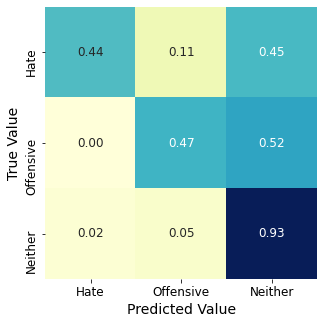

In [105]:
#Confusion Matrix for TFIDF with additional features 
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [141]:
# From the confusion matrix its clear that the model misclassifies 78% of the hate data as offensive data. This explains the reduction in class-0
# bar on the histogram for the predicted class and increase of bar for class-1 (offensive).

In [106]:
testing_index=list(X_test_features.index[0:10])
#print(testing_index)
print("Predicted Class:",y_preds[0:10])
print("Actual Class:",y_test.tolist()[0:10])

Predicted Class: [2 2 2 2 2 1 2 2 2 2]
Actual Class: [2, 2, 2, 2, 2, 2, 0, 2, 0, 2]


Text(0, 0.5, 'Count')

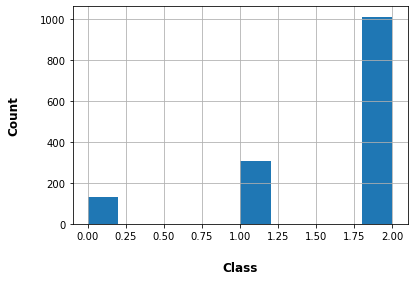

In [107]:
# Histogram presenting the count of different classes- Actual
ax=y_test.hist()
ax.set_xlabel("Class", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Count", labelpad=20, weight='bold', size=12)

Text(0, 0.5, 'Count')

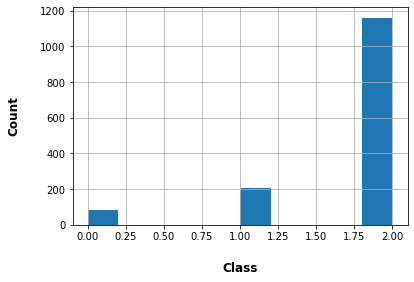

In [108]:
# Histogram presenting the count of different classes- Predicted
ax=panda.Series(y_preds).hist()
ax.set_xlabel("Class", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Count", labelpad=20, weight='bold', size=12)

In [109]:
X = panda.DataFrame(modelling_features_enhanced)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_features,y_train)
y_preds = rf.predict(X_test_features)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.82      0.68      0.74       130
           1       0.91      0.73      0.81       305
           2       0.89      0.96      0.93      1012

    accuracy                           0.89      1447
   macro avg       0.87      0.79      0.83      1447
weighted avg       0.89      0.89      0.88      1447

Random Forest, Accuracy Score: 0.8887353144436766


In [110]:
X = panda.DataFrame(modelling_features_enhanced)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_features,y_train)
y_preds = nb.predict(X_test_features)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.46      0.51      0.48       130
           1       0.49      0.70      0.57       305
           2       0.84      0.72      0.78      1012

    accuracy                           0.70      1447
   macro avg       0.59      0.64      0.61      1447
weighted avg       0.73      0.70      0.71      1447

Naive Bayes, Accuracy Score: 0.695922598479613


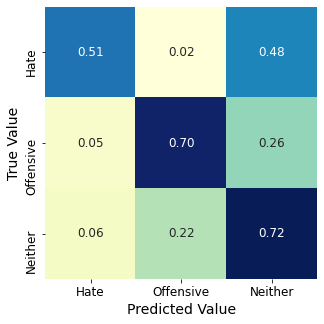

In [111]:
#Confusion Matrix for TFIDF with additional features 
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [112]:
X = panda.DataFrame(modelling_features_enhanced)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test_helo = train_test_split(X, y, random_state=0, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3=accuracy_score(y_test_helo,y_preds)
report = classification_report( y_test_helo, y_preds )
print(report)
print("SVM, Accuracy Score:" ,acc3 )

              precision    recall  f1-score   support

           0       0.82      0.61      0.70       130
           1       0.81      0.85      0.83       305
           2       0.92      0.94      0.93      1012

    accuracy                           0.89      1447
   macro avg       0.85      0.80      0.82      1447
weighted avg       0.89      0.89      0.89      1447

SVM, Accuracy Score: 0.8901174844505875


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


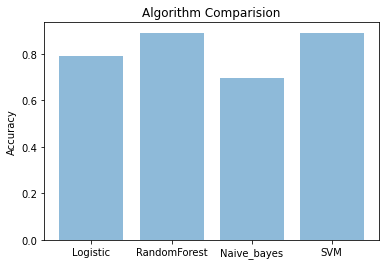

In [113]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision')
plt.show()

## Combining different features

In [114]:
#f1,f3 and f4 combined

tfidf_a = tfidf.toarray()
modelling_features_one = np.concatenate([tfidf_a,doc2vec_df,fFeatures],axis=1)
modelling_features_one.shape

(7232, 2854)

In [115]:
X = panda.DataFrame(modelling_features_one)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" ,acc3 )

/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


              precision    recall  f1-score   support

           0       0.86      0.28      0.43       130
           1       0.48      0.94      0.63       305
           2       0.97      0.77      0.86      1012

    accuracy                           0.76      1447
   macro avg       0.77      0.67      0.64      1447
weighted avg       0.86      0.76      0.77      1447

SVM, Accuracy Score: 0.7629578438147893


In [116]:
#f1,f2 and f4 combined
tfidf_a = tfidf.toarray()
modelling_features_two = np.concatenate([tfidf_a,final_features,fFeatures],axis=1)
modelling_features_two.shape

(7232, 2856)

In [117]:
X = panda.DataFrame(modelling_features_two)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" ,acc3 )

              precision    recall  f1-score   support

           0       0.56      0.94      0.70       130
           1       0.94      0.77      0.85       305
           2       0.93      0.90      0.91      1012

    accuracy                           0.88      1447
   macro avg       0.81      0.87      0.82      1447
weighted avg       0.90      0.88      0.88      1447

SVM, Accuracy Score: 0.8762957843814789


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [118]:
#f2,f3 and f4 combined
modelling_features_three = np.concatenate([final_features,fFeatures],axis=1)
modelling_features_three.shape

(7232, 15)

In [119]:
X = panda.DataFrame(modelling_features_three)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" ,acc3 )

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       0.65      0.47      0.55       305
           2       0.77      0.94      0.85      1012

    accuracy                           0.76      1447
   macro avg       0.47      0.47      0.46      1447
weighted avg       0.68      0.76      0.71      1447

SVM, Accuracy Score: 0.7553559087767795


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [166]:
# the most important feature we found to be was the tf-idf scores which helps in better classification of hate speech.
# Doc2vec columns are not found to be very significant in classification purpose as it makes very less difference when 
#its removed form the feature set. SVM's and RF's performance is hugely impacted when tf-idf scores are not included in the feature set.

In [120]:
X = panda.DataFrame(modelling_features_two)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_features,y_train)
y_preds = nb.predict(X_test_features)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.46      0.51      0.48       130
           1       0.49      0.70      0.57       305
           2       0.84      0.72      0.78      1012

    accuracy                           0.70      1447
   macro avg       0.59      0.64      0.61      1447
weighted avg       0.73      0.70      0.71      1447

Naive Bayes, Accuracy Score: 0.695922598479613


In [168]:
# Naive Baiyes Classifier performs significantly better with feature set of f-2,3,4 which 
#actually performs poor for Logistic Regression especially in prediction of "hate" label.

In [121]:
X = panda.DataFrame(modelling_features_two)
y = dataset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

model = LogisticRegression().fit(X_train,y_train)
y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.62      0.35      0.45       130
           1       0.70      0.42      0.53       305
           2       0.79      0.93      0.86      1012

    accuracy                           0.77      1447
   macro avg       0.71      0.57      0.61      1447
weighted avg       0.76      0.77      0.75      1447

Logistic Regression, Accuracy Score: 0.774015203870076


/Users/kavitaselva/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [122]:
X = panda.DataFrame(modelling_features_three)
y = dataset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_preds = rf.predict(X_test)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.53      0.38      0.45       130
           1       0.61      0.43      0.50       305
           2       0.79      0.90      0.84      1012

    accuracy                           0.75      1447
   macro avg       0.65      0.57      0.60      1447
weighted avg       0.73      0.75      0.73      1447

Random Forest, Accuracy Score: 0.7505183137525916


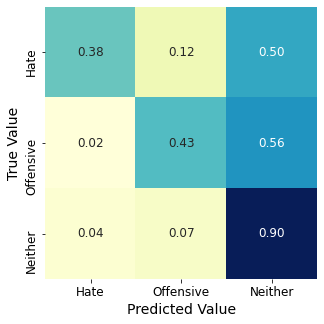

In [123]:
#Confusion Matrix for TFIDF with additional features 
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)